<a href="https://colab.research.google.com/github/nidhi7330/nidhi7330/blob/main/Tour_Content_based_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


In [123]:
#reding the dataset
tour_desc = pd.read_csv('/content/tour_final.csv')#,encoding = 'utf-8')


In [124]:
#Give the number of rows and columns
tour_desc.shape

(199, 11)

In [125]:
#To get the overview of the dataset
tour_desc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Count       199 non-null    int64  
 1   Title       199 non-null    object 
 2   Vote_count  199 non-null    int64  
 3   Rating      199 non-null    float64
 4   Category    180 non-null    object 
 5   Days        199 non-null    object 
 6   Location    199 non-null    object 
 7   Keywords    199 non-null    object 
 8   Country     199 non-null    object 
 9   Price       199 non-null    int64  
 10  Image_url   199 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 17.2+ KB


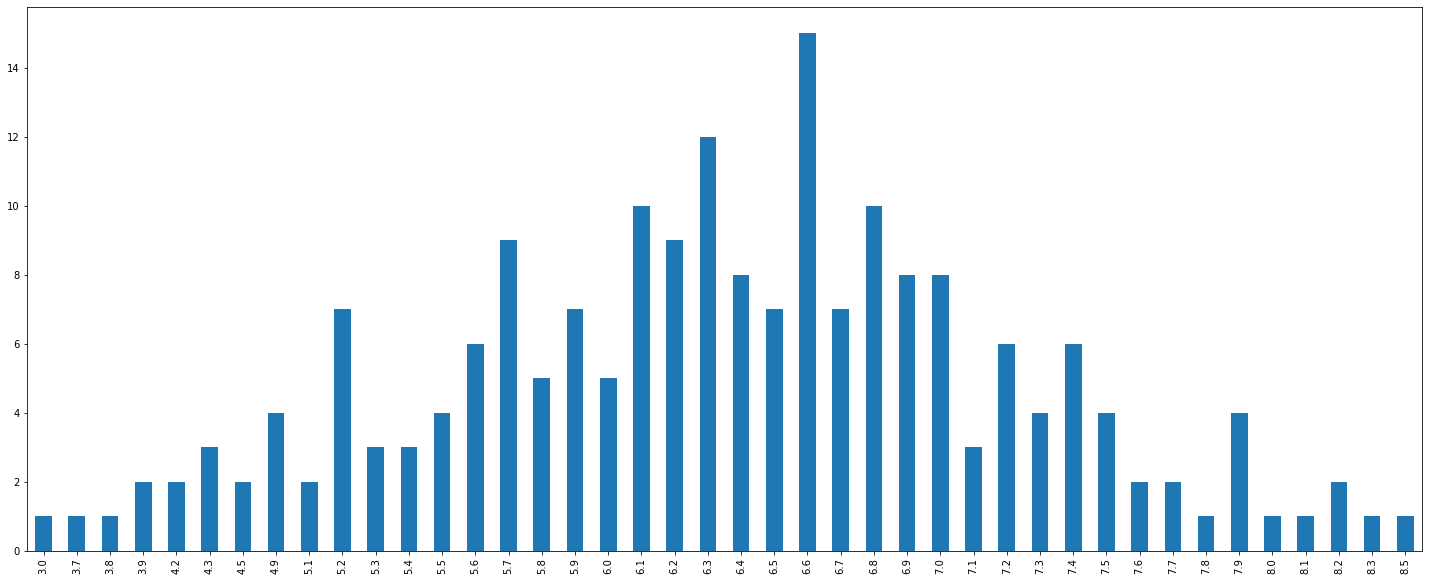

In [126]:
#Generating graph on the basis of Price distribution
tour_desc['Rating'].value_counts(dropna=False).sort_index().plot(kind= 'bar', figsize=(25,10))

In [128]:
#Calculating the mean of Rating
C = tour_desc['Rating'].mean()

In [129]:
#Calculating Quantile range on the basis of Vote_count
m =  tour_desc['Vote_count'].quantile(0.10)

In [130]:
## Filtering all the tour that have vote_count more than 'm'
quali =  tour_desc.copy().loc[ tour_desc['Vote_count'] >= m]
quali.shape

(180, 11)

In [131]:
# Calculating the weighted rating of each tour package
def weighted_rate(v, R, m=m, C=C):
  ans = (v/(v+m) * R)+(m/(v+m) * C)
  return ans


In [132]:
quali['Score'] = quali.apply(lambda row : weighted_rate(row['Vote_count'], row['Rating']), axis = 1)


In [133]:
quali = quali.sort_values('Score', ascending=False)


In [134]:
(quali
 .query('Location == "Uttarpradesh"')
 .sort_values('Score', ascending=False).head(10))

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score
94,201639,ShershahSuri 's Tomb,567,8.1,Pilgrimage,8N 9D,Uttarpradesh,built in memory of Emperor Sher Shah Suri,India,15000,https://1.bp.blogspot.com/-A2MRcbMrHZU/WScWZE7...,7.973823
106,5732,Kohinoor Palace,654,7.9,Heritage,6N 7D,Uttarpradesh,"royal residence, or the home of a head of state",India,10000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.801911
107,5266,Group of Temples,134,8.2,Heritage,7N 8D,Uttarpradesh,reserved for religious or spiritual rituals,India,14000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.740860
79,227668,Jhansi Fort,245,7.8,Fort,9N 10D,Uttarpradesh,Jhansi ka Kila is a fortress,India,22000,https://icdn.isrgrajan.com/in/2017/05/Jhansi-F...,7.577542
0,5419608,Taj Mahal,167,7.9,Architecture,2N 3D,Uttarpradesh,immense mausoleum of white marble,India,8500,https://cdn.britannica.com/86/170586-050-AB7FE...,7.574439
102,22309,Observatory Man Singh,123,7.6,Pilgrimage,4N 5D,Uttarpradesh,famous as a masonry observatory,India,6500,https://i2.wp.com/varanasivideos.com/wp-conten...,7.265856
1,1799953,Agra Fort,158,7.2,Fort,3N 4D,Uttarpradesh,historical fort in Agra,India,10000,https://www.fabhotels.com/blog/wp-content/uplo...,7.009613
117,63206,Mehtab Bagh,789,7.0,Pilgrimage,4N 5D,Uttarpradesh,perfectly aligned with the Taj Mahal,India,5000,http://res.cloudinary.com/dwzmsvp7f/image/uplo...,6.964342
98,52559,Laxman Temple Sirpur,567,6.8,Heritage,5N 6D,Uttarpradesh,7th-century brick temple,India,6700,https://new-img.patrika.com/upload/2018/04/30/...,6.765463
96,185316,Remains of Patliputra Kumrahar,678,6.6,Wildlife,9N 10D,Uttarpradesh,ancient city of Pataliputra,India,20000,https://greatindianjourney.files.wordpress.com...,6.582708


In [136]:
conbas_df = quali[['Title','Category','Days','Location','Keywords','Image_url']]


In [139]:
#converting the names and keyword instances into lowercase and strip all the spaces between them #comparing the code with keywords
conbas_df['Category'] = conbas_df['Category'].str.replace(' ','').str.lower().str.replace('-','')
conbas_df['Location'] = conbas_df['Location'].str.replace(' ','').str.lower().str.replace('-',' ')
conbas_df['Days'] = conbas_df['Days'].str.replace(' ','').str.lower().str.replace('-',' ')
#conbas_df['Image_url'] = conbas_df['Image_url'].str.replace(' ','').str.lower().str.replace('-','')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [140]:
 conbas_df['Keywords'] = conbas_df['Keywords'].replace(np.nan, 'Not Available')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
conbas_df['soup'] = conbas_df['Keywords'] + ' ' + conbas_df['Category'] + ' ' + conbas_df['Days'] + ' ' + conbas_df['Location'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
conbas_df.columns


Index(['Title', 'Category', 'Days', 'Location', 'Keywords', 'Image_url',
       'soup'],
      dtype='object')

In [143]:
conbas_df = conbas_df.drop(columns=['Category','Days','Location','Keywords','Image_url'])


In [144]:
conbas_df.head()


,Title,soup
46,KotlaFeroz Shah,built by Sultan Feroz Shah Tughlaq pilgrimage ...
49,Sultanghari 's Tomb,implanted in a Ghari (cave) heritage 7n8d delhi
94,ShershahSuri 's Tomb,built in memory of Emperor Sher Shah Suri pil...
5,Krabi,"province characterized by craggy, sheer limest..."
57,Ranghar Pavillion Jaisagar,constructed to watch cultural programs and gam...


In [145]:
conbas_df.shape


(180, 2)

In [146]:
q = pd.merge(quali,conbas_df, left_on=['Title'], right_on=['Title'], how='left')


In [147]:
conbas_df.head()

,Title,soup
46,KotlaFeroz Shah,built by Sultan Feroz Shah Tughlaq pilgrimage ...
49,Sultanghari 's Tomb,implanted in a Ghari (cave) heritage 7n8d delhi
94,ShershahSuri 's Tomb,built in memory of Emperor Sher Shah Suri pil...
5,Krabi,"province characterized by craggy, sheer limest..."
57,Ranghar Pavillion Jaisagar,constructed to watch cultural programs and gam...


In [148]:
q[q['Category'].str.contains('Heritage', na=False)]

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score,soup
1,1408,Sultanghari 's Tomb,348,8.2,Heritage,7N 8D,Delhi,implanted in a Ghari (cave),India,10900,https://s3.us-east-1.amazonaws.com/media.archn...,7.992154,implanted in a Ghari (cave) heritage 7n8d delhi
3,215845,Krabi,890,7.9,Heritage,5N 6D,southern Thailand,"province characterized by craggy, sheer limest...",Thailand,10000,https://cdn.thecrazytourist.com/wp-content/upl...,7.826723,"province characterized by craggy, sheer limest..."
4,106925,Ranghar Pavillion Jaisagar,773,7.9,Heritage,5N 6D,Assam,constructed to watch cultural programs and games,India,5000,https://upload.wikimedia.org/wikipedia/commons...,7.816216,constructed to watch cultural programs and gam...
5,5732,Kohinoor Palace,654,7.9,Heritage,6N 7D,Uttarpradesh,"royal residence, or the home of a head of state",India,10000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.801911,"royal residence, or the home of a head of stat..."
6,5266,Group of Temples,134,8.2,Heritage,7N 8D,Uttarpradesh,reserved for religious or spiritual rituals,India,14000,https://encrypted-tbn0.gstatic.com/images?q=tb...,7.740860,reserved for religious or spiritual rituals he...
18,358540,Daria Daulat Bagh,654,7.3,Heritage,5N 6D,Karnataka,Garden of the Sea of Wealth,India,10000,https://res.cloudinary.com/doivakz2v/image/upl...,7.238927,Garden of the Sea of Wealth heritage 5n6d karn...
24,48834,The Palace Situated at Burhapur,412,7.2,Heritage,7N 8D,MadhyPradesh,situated on the north bank of the Tapti River,India,17500,https://www.mptourism.com/images/point-of-inte...,7.115895,situated on the north bank of the Tapti River ...
26,16725,Undavalli,678,7.1,Heritage,6N 7D,AndraPradesh,caves were carved out of solid sandstone,India,6000,https://www.themysteriousindia.net/wp-content/...,7.052888,caves were carved out of solid sandstone heri...
30,299893,Rani-ki-Vav Patan,654,7.0,Heritage,9N 10D,Gujarat,stepwell situated in the town of Patan,India,22000,https://upload.wikimedia.org/wikipedia/commons...,6.957435,stepwell situated in the town of Patan herita...
32,68877,Guntupalli,348,7.0,Heritage,4N 5D,AndraPradesh,census town in Krishna district,India,4500,https://pbs.twimg.com/media/DwxeP6BUUAA06zK.jpg,6.924123,census town in Krishna district heritage 4n5d...


In [149]:
q.shape


(180, 13)

In [150]:
q[q.duplicated(['Title'])]

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score,soup


In [111]:
#q = q.drop(columns=['Count','Vote_count','Rating','Keywords','Price'])

In [151]:
q.to_csv('/content/travel.csv')


In [152]:
q.head()

,Count,Title,Vote_count,Rating,Category,Days,Location,Keywords,Country,Price,Image_url,Score,soup
0,82419,KotlaFeroz Shah,654,8.3,Pilgrimage,6N 7D,Delhi,built by Sultan Feroz Shah Tughlaq,India,6500,https://static.toiimg.com/photo/68271442.cms,8.177234,built by Sultan Feroz Shah Tughlaq pilgrimage ...
1,1408,Sultanghari 's Tomb,348,8.2,Heritage,7N 8D,Delhi,implanted in a Ghari (cave),India,10900,https://s3.us-east-1.amazonaws.com/media.archn...,7.992154,implanted in a Ghari (cave) heritage 7n8d delhi
2,201639,ShershahSuri 's Tomb,567,8.1,Pilgrimage,8N 9D,Uttarpradesh,built in memory of Emperor Sher Shah Suri,India,15000,https://1.bp.blogspot.com/-A2MRcbMrHZU/WScWZE7...,7.973823,built in memory of Emperor Sher Shah Suri pil...
3,215845,Krabi,890,7.9,Heritage,5N 6D,southern Thailand,"province characterized by craggy, sheer limest...",Thailand,10000,https://cdn.thecrazytourist.com/wp-content/upl...,7.826723,"province characterized by craggy, sheer limest..."
4,106925,Ranghar Pavillion Jaisagar,773,7.9,Heritage,5N 6D,Assam,constructed to watch cultural programs and games,India,5000,https://upload.wikimedia.org/wikipedia/commons...,7.816216,constructed to watch cultural programs and gam...


In [153]:
q['soup'].head()


0    built by Sultan Feroz Shah Tughlaq pilgrimage ...
1      implanted in a Ghari (cave) heritage 7n8d delhi
2     built in memory of Emperor Sher Shah Suri pil...
3    province characterized by craggy, sheer limest...
4    constructed to watch cultural programs and gam...
Name: soup, dtype: object

In [154]:
# removing the stop words
from sklearn.feature_extraction.text import CountVectorizer
tour_tfidf = CountVectorizer(stop_words='english')
# computing TF-IDF matrix required for calculating cosine similarity
tour_matrix = tour_tfidf.fit_transform(tour_desc['Keywords'].values.astype('U'))

In [155]:
tour_matrix.shape


(199, 583)

In [156]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tour_matrix, tour_matrix)

In [157]:
# Reset index of your main DataFrame and construct reverse mapping as before
q = q.reset_index()
indices = pd.Series(q.index, index=q['Title'])
# indices1 = pd.Series(q.index, index=q['Rating'])
# indices = pd.Series(q.index, index=q['Price'])



In [158]:
def get_recommendations(Title, cosine_sim = cosine_sim):
    idx = indices[Title]
    idx -=1  # Get the index of the Destination that matches the title
    sim_scores = list(enumerate(cosine_sim[idx]))   # Get the pairwsie similarity scores of all Destinations with that Destination
    #print(sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)  # Sort the Destinations based on the similarity scores
    #print(sim_scores)
    sim_scores = sim_scores[1:11]  # Get the scores of the 15 most similar Destinations
    #print(sim_scores)
    Tour_indices = [i[0] for i in sim_scores]  # Get the Destination indices
    Tour = q.iloc[Tour_indices][['Title', 'Rating','Price','Image_url']]

    return tour_desc['Title'].iloc[Tour_indices]

In [159]:
get_recommendations("Taj Mahal")

74                Hazardwari Palace
81                       Rani Mahal
19                   Royal Palaces 
140                            Bhuj
143                        Junagarh
0                         Taj Mahal
1                         Agra Fort
2           Tomb of Akbar the Great
3                   Botanic Gardens
4      Sungei Buloh Wetland Reserve
Name: Title, dtype: object

In [161]:
get_recommendations("Krabi")

119         Mariam's Tomb Sikandara
45                  Safdarjung Tomb
94             ShershahSuri 's Tomb
0                         Taj Mahal
1                         Agra Fort
3                   Botanic Gardens
4      Sungei Buloh Wetland Reserve
5                             Krabi
6                         Kathmandu
7                      Colombo Fort
Name: Title, dtype: object

In [163]:
get_recommendations("Nature Zone Resort")

145                    Modhera
51               Caves, Badami
62                     Bellary
111          Rani-ki-Vav Patan
80               SahetSravasti
115             Fatehpur Sikri
0                    Taj Mahal
1                    Agra Fort
2      Tomb of Akbar the Great
3              Botanic Gardens
Name: Title, dtype: object

In [164]:
get_recommendations("Royal Palaces ")

7                         Colombo Fort
96      Remains of Patliputra Kumrahar
32                 Surajkund Faridabad
65                            Warangal
87                   Karla Caves Karla
114    BabaPyara & Khapra Kodiya Caves
123                       Ajanta Caves
140                               Bhuj
141                             Dwarka
0                            Taj Mahal
Name: Title, dtype: object